# Interest Rate Prediction

### Setup and Loading the Dataset

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Load dataset
url = "https://fred.stlouisfed.org/series/FEDFUNDS"
data = pd.read_csv("FEDFUNDS.csv")

# Data inspection
print(data.head())
print(data.info())


         DATE  FEDFUNDS
0  1954-07-01      0.80
1  1954-08-01      1.22
2  1954-09-01      1.07
3  1954-10-01      0.85
4  1954-11-01      0.83
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DATE      844 non-null    object 
 1   FEDFUNDS  844 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.3+ KB
None


### Data Preprocessing and Feature Engineering

In [8]:
# Data preprocessing
# Convert date to datetime format and filter for relevant data
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.set_index('DATE')

# Remove rows with missing values
data = data.dropna()

# Feature engineering
# Use lagged interest rates as features
data['Lag_1'] = data['FEDFUNDS'].shift(1)
data['Lag_2'] = data['FEDFUNDS'].shift(2)
data['Lag_3'] = data['FEDFUNDS'].shift(3)
data = data.dropna()

# Define input features (X) and target variable (y)
X = data[['Lag_1', 'Lag_2', 'Lag_3']]
y = data['FEDFUNDS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Standardization

In [9]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Building and Compiling the Initial Model

#### RNN model w/ lstm


In [10]:
# Data preprocessing
data = pd.read_csv("FEDFUNDS.csv")

# normalize percentages to [0, 1]
data['FEDFUNDS'] = data['FEDFUNDS'] / 100

# combine into one dataframe
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.set_index('DATE')

In [11]:
#data preparing and splitting
def create_dataset(data, window=24):
    datanp = np.array(data)
    X, y = [], []
    for i in range(len(datanp) - window):
        X.append([x for x in datanp[i:i+window]])
        y.append(datanp[i+window])
    return np.array(X).astype('float32'), np.array(y).astype('float32')

#defining the sliding window & making input/output datasets and train test splits
window_size = 48
X, y = create_dataset(data, window_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(636, 48, 1) (636, 1)
(160, 48, 1) (160, 1)


In [12]:
print(X_train)

[[[0.0531]
  [0.0529]
  [0.0525]
  ...
  [0.1761]
  [0.1098]
  [0.0947]]

 [[0.0612]
  [0.0591]
  [0.0578]
  ...
  [0.0545]
  [0.0553]
  [0.0592]]

 [[0.1331]
  [0.1237]
  [0.1322]
  ...
  [0.079 ]
  [0.0792]
  [0.0799]]

 ...

 [[0.0461]
  [0.0468]
  [0.0469]
  ...
  [0.1281]
  [0.1585]
  [0.189 ]]

 [[0.0811]
  [0.0781]
  [0.0731]
  ...
  [0.0426]
  [0.0447]
  [0.0473]]

 [[0.0292]
  [0.03  ]
  [0.0298]
  ...
  [0.0553]
  [0.0576]
  [0.054 ]]]


In [13]:
#defining the LSTM model
model = Sequential([#first LSTM layer
    Dropout(0.2),#dropout to reduce overfitting
    LSTM(32, return_sequences=False),#second LSTM layer
    Dense(16, activation='relu'),#ReLU activation function in layer
    Dense(1)#output layer
])

#compile the model with Adam optimizer and mean squared error loss function
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
#train the model for 40 epochs
model.fit(X_train, y_train, epochs=40)

Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0022 - mae: 0.0354
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7359e-04 - mae: 0.0165
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8793e-04 - mae: 0.0123
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5573e-04 - mae: 0.0115
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9691e-04 - mae: 0.0104
Epoch 6/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4008e-04 - mae: 0.0109
Epoch 7/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.0936e-04 - mae: 0.0107
Epoch 8/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0187e-04 - mae: 0.0100
Epoch 9/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3876e-04 - mae: 0.0106
Epoch 10/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7199e-04 - mae: 0.0091
Epoch 11/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1222e-04 - mae: 0.0097
Epoch 12/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2879e-04 - mae: 0

In [15]:
#generate predictions
model.predict(X)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


array([[ 1.55824004e-02],
       [ 1.32954409e-02],
       [ 1.28695956e-02],
       [ 1.30214831e-02],
       [ 1.33456392e-02],
       [ 1.45348003e-02],
       [ 1.59056149e-02],
       [ 1.72524974e-02],
       [ 1.83586963e-02],
       [ 1.99511722e-02],
       [ 2.15919018e-02],
       [ 2.28824131e-02],
       [ 2.47967616e-02],
       [ 2.65443176e-02],
       [ 2.80513205e-02],
       [ 2.97330841e-02],
       [ 3.14950608e-02],
       [ 3.29811759e-02],
       [ 3.41705009e-02],
       [ 3.51157561e-02],
       [ 3.58161367e-02],
       [ 3.61141078e-02],
       [ 3.64145264e-02],
       [ 3.65015902e-02],
       [ 3.56664844e-02],
       [ 3.47059630e-02],
       [ 3.34052071e-02],
       [ 3.16075310e-02],
       [ 2.98215151e-02],
       [ 2.82377936e-02],
       [ 2.61138044e-02],
       [ 2.34088376e-02],
       [ 2.29842290e-02],
       [ 2.18166225e-02],
       [ 1.99819282e-02],
       [ 1.93006210e-02],
       [ 1.83619112e-02],
       [ 1.66627355e-02],
       [ 1.6

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


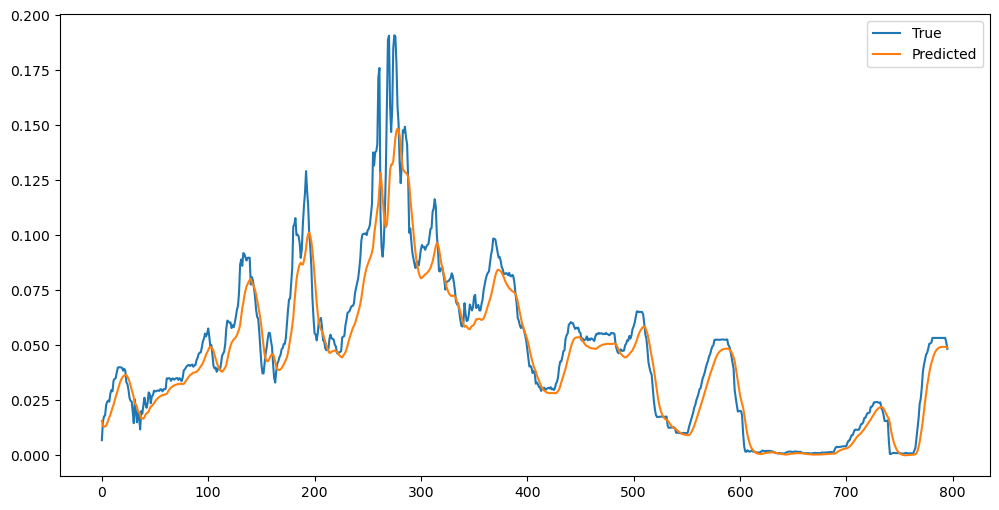

In [16]:
# plotting both the predictions and the test data
y_pred = model.predict(X)
plt.figure(figsize=(12, 6))
plt.plot(y, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


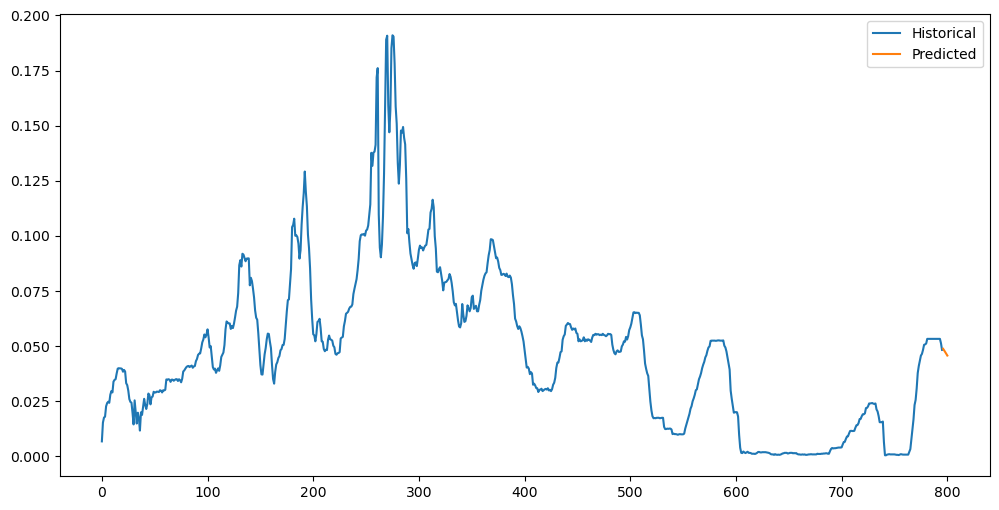

In [17]:
#predicting interest rates for the next few months using the trained model
def predict_interest_rates(months=5):
    last_window = X[-1] #start 
    predictions = []
    for i in range(months):
        prediction = model.predict(np.array([last_window])) #predict next step
        predictions.append(prediction[0]) #store prediction
        last_window = np.append(last_window[1:], prediction, axis=0) #update window
    return predictions
#use prediction function to predict interest rates for the next 5 months
predictions = predict_interest_rates(5)
#plot data
plt.figure(figsize=(12, 6))
plt.plot(y, label='Historical')
plt.plot(range(len(y), len(y) + len(predictions)), predictions, label='Predicted')
plt.legend()
plt.show()

In [18]:
# display last few rows to check recent values
data.tail()

,FEDFUNDS
DATE,
2024-06-01,0.0533
2024-07-01,0.0533
2024-08-01,0.0533
2024-09-01,0.0513
2024-10-01,0.0483
